In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
from matplotlib import pyplot as plt
from pycaret.regression import *
from pycaret.utils import check_metric

## 1. Frame the problem and look at the big picture

I denne oppgaven tar vi for oss problemet Titanic: Machine Learning from Disaster. Dette problemet går ut på å
utvikle en maskinlæringsalgortime som skal kunne forutse hvilke passasjerer som overlevde forliset. Første steg av denne prosessen er å få tak i datasettene som trengs fra Kaggle.

## 2. Get the data
Datene blir lastet inn fra CVS filer

In [2]:
train = pd.read_csv('data/titanic/train.csv')
test = pd.read_csv('data/titanic/test.csv')

## 3. Explore the data to gain insight
I første omgang ser en på hvilke kolonner en har å jobbe med. 

In [3]:
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


Ved å ta en rask kikk på noen rader i treningssettet, ser en at en har litt ulike data som numerisk, kategoriske, strenger og uoppgitte data. Noen av disse krever litt arbeid om en vil lage dataene brukbar for en modell.

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Her ser en på litt mer konkret info angående dataene, hvilke kolonner som mangler variabler og hvilke data typer. Cabin og Age er de som skiller seg mest ut her med tanke på manglende data.

In [5]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


describe kan brukes for å få en bedre forståelse for de forskjellige numeriske dataene i datasettet.

- Gjennsomsnitt var 38,4% som overlvede forliset.
- Den gjennsomsnitlige passasjerklassen var 2.3, noe som sier oss at en majoritet av passasjerene var av klasse 2 og 3.
- Den gjennomsnittlige alderen på passasjerer fra 29,6 år. Dette forteller oss at enten veldig mange unge reiste med Titanic, eller så var det flere fammilere med unge barn som reiste.
- Det var i gjennomsnittlig litt over halvparten av alle passasjerene reiste med søsken eller ektefelle.
- Hver passasjer betalte i gjennomsnitt 32.2 i da tidens dollar for reisen.

Videre kan en se på fordelingen av verdier innen disse numeriske kolonnene

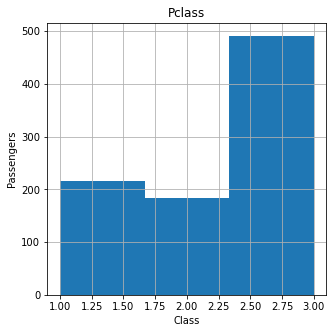

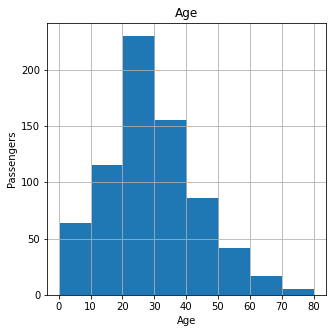

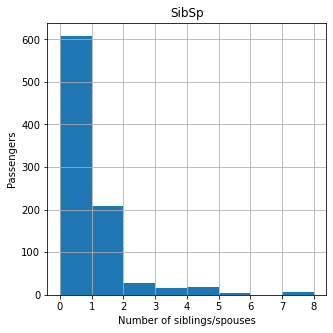

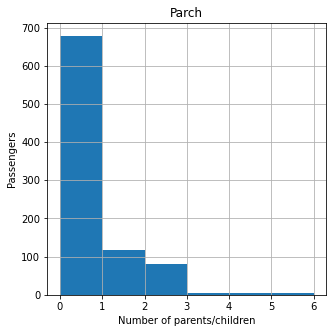

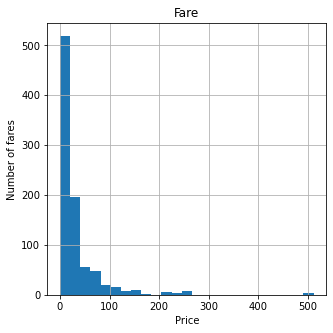

In [6]:
train['Pclass'].hist(bins=3, figsize=(5,5))
plt.ylabel("Passengers", fontsize=10)
plt.xlabel("Class", fontsize=10)
plt.title('Pclass')
plt.show()

train['Age'].hist(bins=8, figsize=(5,5))
plt.ylabel("Passengers", fontsize=10)
plt.xlabel("Age", fontsize=10)
plt.title('Age')
plt.show()

train['SibSp'].hist(bins=8, figsize=(5,5))
plt.ylabel("Passengers", fontsize=10)
plt.xlabel("Number of siblings/spouses", fontsize=10)
plt.title('SibSp')
plt.show()

train['Parch'].hist(bins=6, figsize=(5,5))
plt.ylabel("Passengers", fontsize=10)
plt.xlabel("Number of parents/children", fontsize=10)
plt.title('Parch')
plt.show()

train['Fare'].hist(bins=25, figsize=(5,5))
plt.ylabel("Number of fares", fontsize=10)
plt.xlabel("Price", fontsize=10)
plt.title('Fare')
plt.show()



En kan se at Age har en normal distribusjon, mens SibSp, Parch og Fare har en veldig ujevn distribusjon.

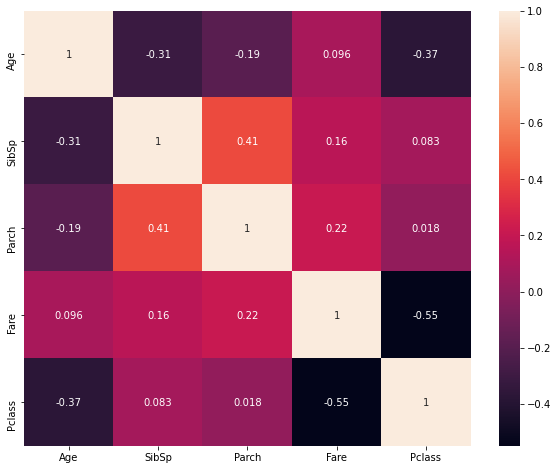

In [7]:
trainNum = train[['Age','SibSp','Parch','Fare', 'Pclass']]
pd.options.display.float_format = '{:,.3f}'.format
plt.figure(figsize=(10,8))
sns.heatmap(trainNum.corr(), annot=True)
plt.show()

Dette er et heatmap over de forskjellige numeriske kolonnene i datasettet. Dette er for å se om det er noe korrelasjon mellom kolonnene, som kan være nyttig om en ønsker å konstruere flere kolonner senere. Her er en hovesakelig intererssert i data som har har en så høy som mulig korrelasjon (positiv og negativ), alstå så nærme 1/-1 som mulig.

Parch (# av foreldre / barn ombord på Titanic) og SibSp (# av søsken / ektefeller ombord på Titanic) har en relavtiv høy korrelasjon på 0.41.

Det er også en korrelasjon mellom prisen på reisen og hvilke klasse den reisende har, samt klasse og alder. Disse verdiene kan ikke nødvendigvis enkelt kombineres, men å sette kolonnene ved siden av hverandre kan har en positiv effekt for modellen.

In [8]:
train = train[['PassengerId','Survived','Parch','SibSp','Age','Pclass','Fare','Cabin','Ticket','Embarked','Sex']]

In [9]:
train.head(5)

,PassengerId,Survived,Parch,SibSp,Age,Pclass,Fare,Cabin,Ticket,Embarked,Sex
0,1,0,0,1,22.000,3,7.250,NaN,A/5 21171,S,male
1,2,1,0,1,38.000,1,71.283,C85,PC 17599,C,female
2,3,1,0,0,26.000,3,7.925,NaN,STON/O2. 3101282,S,female
3,4,1,0,1,35.000,1,53.100,C123,113803,S,female
4,5,0,0,0,35.000,3,8.050,NaN,373450,S,male


Her har kolonnene fått endret rekkefølge og navn har blitt droppet.

Når det gjelder de kategoriske kolonnene, er det mulig å se litt på fordelingen i form av plots og med mer presise numeriske data. Her må det også mulig bli gjort litt generalisering av dataene for å få en bedre innsikt.

In [10]:
trainCat = train[['Survived','Sex', 'Embarked', 'Cabin', 'Ticket']]

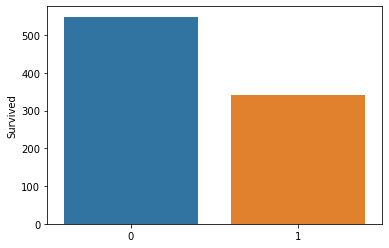

In [11]:
sns.barplot(train['Survived'].value_counts().index, train['Survived'].value_counts())
plt.show()

Her ser en andelen som overlevde (1) og som ikke gjorde det (0)

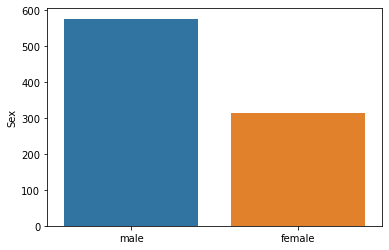

In [12]:
sns.barplot(train['Sex'].value_counts().index, train['Sex'].value_counts())
plt.show()

In [13]:
print(pd.pivot_table(train, index = 'Survived', columns = 'Sex' , values = 'Ticket', aggfunc = 'count'))

Sex       female  male
Survived              
0             81   468
1            233   109


Her ser en at det var mange flere menn ombord, men at det var flest kvinner som overlevde

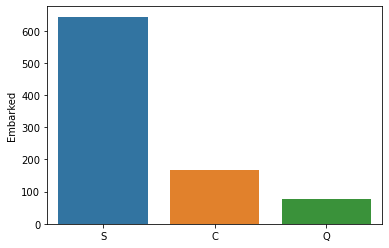

In [14]:
sns.barplot(train['Embarked'].value_counts().index, train['Embarked'].value_counts())
plt.show()

In [15]:
print(pd.pivot_table(train, index = 'Survived', columns = 'Embarked' , values = 'Ticket', aggfunc = 'count'))

Embarked   C   Q    S
Survived             
0         75  47  427
1         93  30  217


Her ser en hvor mange som gikk ombord på hver havn. Her ser en at det er lavest sjanse for å overleve med ombordstigning på havn S.

In [16]:
train['Cabin'] = train['Cabin'].str[0]
train['Cabin'] = train['Cabin'].replace(np.nan, 'X')

For å dele opp dataene i litt færre kolonner kan en ta en grov kategorisering basert på første bokstav. De kolonnene med ikke oppgitt data, blir satt til X.

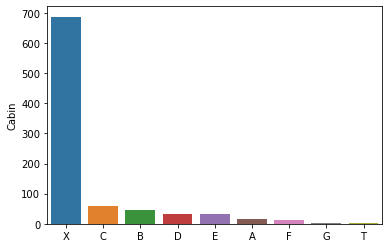

In [17]:
sns.barplot(train['Cabin'].value_counts().index, train['Cabin'].value_counts())
plt.show()

In [18]:
print(pd.pivot_table(train, index = 'Survived', columns = 'Cabin' , values = 'Ticket', aggfunc = 'count'))

Cabin        A      B      C      D      E     F     G     T       X
Survived                                                            
0        8.000 12.000 24.000  8.000  8.000 5.000 2.000 1.000 481.000
1        7.000 35.000 35.000 25.000 24.000 8.000 2.000   nan 206.000


Nå kan en se en stor forskjell mellom overlevelsesraten for hver av cabin grupperingene hvor E, D og B gjør det best.

In [19]:
train.loc[train['Ticket'].str[0].str.isnumeric(), 'Ticket'] = "X " + train['Ticket']
train[['TicketStr', 'TicketNum']] = train['Ticket'].str.split(' ', 1, expand=True)
train['TicketStr'] = train['TicketStr'].str[0]
train['TicketNum'] = train['TicketNum'].str[0]

For Ticket, kreves litt mer arbeid. Først får numeriske verdier lagt til en X og deretter blir kolonnen splittet i 2 og får verdi lik første tegn hvor TicketStr har tekst verdi og TicketNum har tallverdi.

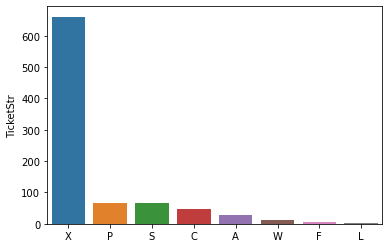

In [20]:
sns.barplot(train['TicketStr'].value_counts().index, train['TicketStr'].value_counts())
plt.show()

In [21]:
print(pd.pivot_table(train, index = 'Survived', columns = 'TicketStr' , values = 'Ticket', aggfunc = 'count'))

TicketStr   A   C  F  L   P   S   W    X
Survived                                
0          27  31  3  3  23  44  11  407
1           2  16  4  1  42  21   2  254


En ser her at enkelte bokstaver som A og W har veldig lav overlevelsesrate, mens P har en veldig høy en. Det er også flest som ikke har oppgitt Cabin.

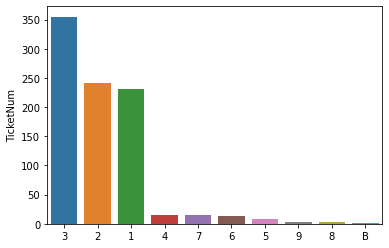

In [22]:
sns.barplot(train['TicketNum'].value_counts().index, train['TicketNum'].value_counts())
plt.show()

In [23]:
print(pd.pivot_table(train, index = 'Survived', columns = 'TicketNum' , values = 'Ticket', aggfunc = 'count'))

TicketNum       1       2       3      4     5      6      7     8     9     B
Survived                                                                      
0          91.000 143.000 265.000 13.000 7.000 13.000 11.000 3.000   nan   nan
1         140.000  99.000  90.000  2.000 1.000  1.000  4.000   nan 3.000 1.000


Her ser en at de fleste har cabintall som starter på 1, 2 eller 3. En kan også se at overlevelsesraten er lav for de fleste verdier untatt 1. 

## 4. Prepare the data to better expose the underlying data patterns to machine learning algorithms

Nå som dataene er sett på, kan en begynne å fikse på dataene slik at de er bedre tilpasset maskinlæring.

In [24]:
train.head()

,PassengerId,Survived,Parch,SibSp,Age,Pclass,Fare,Cabin,Ticket,Embarked,Sex,TicketStr,TicketNum
0,1,0,0,1,22.000,3,7.250,X,A/5 21171,S,male,A,2
1,2,1,0,1,38.000,1,71.283,C,PC 17599,C,female,P,1
2,3,1,0,0,26.000,3,7.925,X,STON/O2. 3101282,S,female,S,3
3,4,1,0,1,35.000,1,53.100,C,X 113803,S,female,X,1
4,5,0,0,0,35.000,3,8.050,X,X 373450,S,male,X,3


In [25]:
cab = train.loc[train['Cabin'] == 'X']["Survived"]
cabSurv = sum(cab)/len(cab)

Ved å kjøre denne på alle grupperingene inne i Cabin, vil en finne overlevelsesraten for hver av gruppene.

A: 0.46,  G: 0.5,  F: 0.61,  E: 0.75,  D: 0.75,  B: 0.75,  C: 0.59,  X: 0.3

In [26]:
train.loc[(train['Cabin'] == 'X') | (train['Cabin'] == 'T'), 'Cabin'] = 30
train.loc[(train['Cabin'] == 'A') | (train['Cabin'] == 'G'), 'Cabin'] = 46
train.loc[(train['Cabin'] == 'C') | (train['Cabin'] == 'F'), 'Cabin'] = 60
train.loc[(train['Cabin'] == 'E') | (train['Cabin'] == 'D') | (train['Cabin'] == 'B'), 'Cabin'] = 75
train['Cabin'] = train.Cabin.astype(int)

En kan deretter kombinere grupper med tilnærmet lik overlevelsesrate sammen. Her blir verdien satt basert på overlevelsesraten.

In [27]:
train.Cabin.head(5)

0    30
1    60
2    30
3    60
4    30
Name: Cabin, dtype: int32

Cabin er nå klar til å brukes av modellen.

In [28]:
train.head(5)

,PassengerId,Survived,Parch,SibSp,Age,Pclass,Fare,Cabin,Ticket,Embarked,Sex,TicketStr,TicketNum
0,1,0,0,1,22.000,3,7.250,30,A/5 21171,S,male,A,2
1,2,1,0,1,38.000,1,71.283,60,PC 17599,C,female,P,1
2,3,1,0,0,26.000,3,7.925,30,STON/O2. 3101282,S,female,S,3
3,4,1,0,1,35.000,1,53.100,60,X 113803,S,female,X,1
4,5,0,0,0,35.000,3,8.050,30,X 373450,S,male,X,3


In [29]:
tick = train.loc[train['TicketStr'] == 'X']["Survived"]
tickSurv = sum(tick )/len(tick)

Som med Cabin, så kan en kombinere noen kategorier som er like. Her får en disse verdiene (S, C og X kan slås sammen):

A: 0.06,  W: 0.15,  L: 0.25,  S: 0.32,  C: 0.34,  X: 0.38,  F: 0.57,  P: 0.65

In [30]:
train.loc[(train['TicketStr'] == 'A'), 'TicketStr'] = 6
train.loc[(train['TicketStr'] == 'W'), 'TicketStr'] = 15
train.loc[(train['TicketStr'] == 'L'), 'TicketStr'] = 25
train.loc[(train['TicketStr'] == 'S'), 'TicketStr'] = 34
train.loc[(train['TicketStr'] == 'X'), 'TicketStr'] = 34
train.loc[(train['TicketStr'] == 'C'), 'TicketStr'] = 34
train.loc[(train['TicketStr'] == 'F'), 'TicketStr'] = 57
train.loc[(train['TicketStr'] == 'P'), 'TicketStr'] = 65
train['TicketStr'] = train.TicketStr.astype(int)

In [31]:
train.TicketStr.head(5)

0     6
1    65
2    34
3    34
4    34
Name: TicketStr, dtype: int32

TicketStr er nå klar til å brukes av modellen.

In [32]:
tick = train.loc[train['TicketNum'] == '3']["Survived"]
tickSurv = sum(tick )/len(tick)

Samme repeteres for TicketNum med verdier: 

8: 0.0, 6: 0.07, 5: 0.12, 4: 0.13, 3: 0.25, 7: 0.26, 2: 0.4, 1: 0.6, 9: 1.0, B: 1.0

In [33]:
train["TicketNum"] = train['TicketNum'].replace(np.nan,40)
train.loc[(train['TicketNum'] == '8'), 'TicketNum'] = 0
train.loc[(train['TicketNum'] == '6'), 'TicketNum'] = 7
train.loc[(train['TicketNum'] == '5'), 'TicketNum'] = 13
train.loc[(train['TicketNum'] == '4'), 'TicketNum'] = 13
train.loc[(train['TicketNum'] == '3'), 'TicketNum'] = 25
train.loc[(train['TicketNum'] == '7'), 'TicketNum'] = 22
train.loc[(train['TicketNum'] == '2'), 'TicketNum'] = 40
train.loc[(train['TicketNum'] == '1'), 'TicketNum'] = 60
train.loc[(train['TicketNum'] == '9'), 'TicketNum'] = 100
train.loc[(train['TicketNum'] == 'B'), 'TicketNum'] = 100
train['TicketNum'] = train.TicketNum.astype(int)

In [34]:
train.TicketNum.head(5)

0    40
1    60
2    25
3    60
4    25
Name: TicketNum, dtype: int32

TicketNum er nå klar til å brukes av modellen.

In [35]:
train["TravelTotal"] = train['SibSp'] + train['Parch']

Ettersom det var en høy korrelasjon mellom disse kolonnene, kan en kombinere de til en som er totalt antall personer du reiser med.

In [36]:
train.head(5)

,PassengerId,Survived,Parch,SibSp,Age,Pclass,Fare,Cabin,Ticket,Embarked,Sex,TicketStr,TicketNum,TravelTotal
0,1,0,0,1,22.000,3,7.250,30,A/5 21171,S,male,6,40,1
1,2,1,0,1,38.000,1,71.283,60,PC 17599,C,female,65,60,1
2,3,1,0,0,26.000,3,7.925,30,STON/O2. 3101282,S,female,34,25,0
3,4,1,0,1,35.000,1,53.100,60,X 113803,S,female,34,60,1
4,5,0,0,0,35.000,3,8.050,30,X 373450,S,male,34,25,0


In [37]:
train = train[['PassengerId','Survived','TravelTotal','Parch','SibSp','Age','Pclass','Fare','Cabin','TicketStr','TicketNum','Embarked','Sex']]

In [38]:
train.head(5)

,PassengerId,Survived,TravelTotal,Parch,SibSp,Age,Pclass,Fare,Cabin,TicketStr,TicketNum,Embarked,Sex
0,1,0,1,0,1,22.000,3,7.250,30,6,40,S,male
1,2,1,1,0,1,38.000,1,71.283,60,65,60,C,female
2,3,1,0,0,0,26.000,3,7.925,30,34,25,S,female
3,4,1,1,0,1,35.000,1,53.100,60,34,60,S,female
4,5,0,0,0,0,35.000,3,8.050,30,34,25,S,male


Her har kolonnene fått endret rekkefølge basert på korrelasjon og navn og ticket har blitt droppet.

## 3. Explore the data to gain insight

In [39]:
reg_setup = setup(train, target='Survived', train_size=.95, n_jobs=6, numeric_features = ['SibSp','Parch','Cabin', 'TravelTotal'], 
                 categorical_features = ['TicketStr','TicketNum'], ordinal_features = { 'Pclass' : ['1', '2', '3']}, 
                  ignore_features=[], numeric_imputation='median', normalize=True, normalize_method='robust')

,Description,Value
0,session_id,5987
1,Target,Survived
2,Original Data,"(891, 13)"
3,Missing Values,True
4,Numeric Features,7
5,Categorical Features,5
6,Ordinal Features,True
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(846, 26)"


Her blir dataene behandlet av pycaret setup som blant annet normaliserer dataene, encoder kategoriske kolonner og fyller inn manglende data med median. Her brukes kun 95% av treningsettet brukt i første omgang.

In [40]:
top = compare_models(n_select=5, sort='RMSE', fold=50)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,0.2565,0.1258,0.3465,0.4257,0.2438,0.3330,0.0358
catboost,CatBoost Regressor,0.2433,0.1256,0.3466,0.4266,0.2424,0.3119,2.0848
lightgbm,Light Gradient Boosting Machine,0.2534,0.1325,0.3563,0.3908,0.2514,0.3139,0.1444
rf,Random Forest Regressor,0.2391,0.1374,0.3630,0.3648,0.2559,0.2989,0.1042
br,Bayesian Ridge,0.2961,0.1421,0.3703,0.3527,0.2615,0.3791,0.0050
ridge,Ridge Regression,0.2943,0.1428,0.3709,0.3496,0.2615,0.3755,0.0060
lr,Linear Regression,0.2947,0.1432,0.3714,0.3478,0.2618,0.3755,0.1568
xgboost,Extreme Gradient Boosting,0.2489,0.1511,0.3812,0.3017,0.2639,0.3099,0.5712
ada,AdaBoost Regressor,0.3312,0.1491,0.3813,0.3178,0.2762,0.3565,0.0122
omp,Orthogonal Matching Pursuit,0.3020,0.1515,0.3813,0.3093,0.2699,0.3883,0.0054


Her kjøres hver modell 50 ganger for så å bli sortert basert på RMSE. De 5 beste modellene blir så lagret i top.

In [41]:
top

[GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                           init=None, learning_rate=0.1, loss='ls', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=5987, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0, warm_start=False),
 LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=6, num_leaves=31, objective=None,
               ran

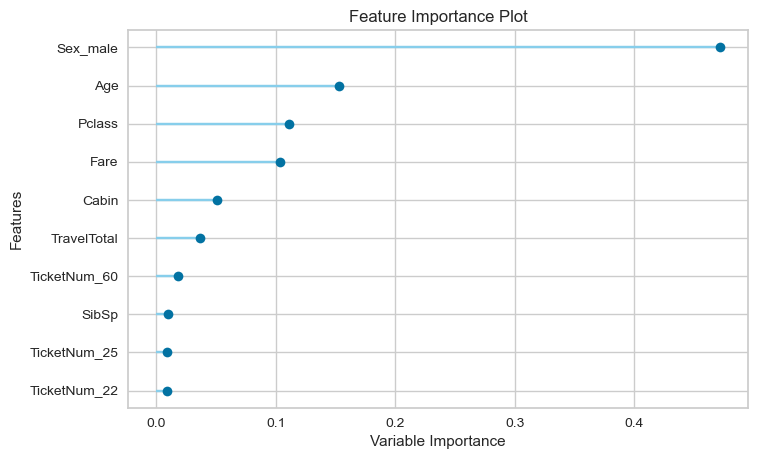

In [42]:
plot_model(top[0], plot='feature')

Feature Importance av Gradient Boosting Regressor

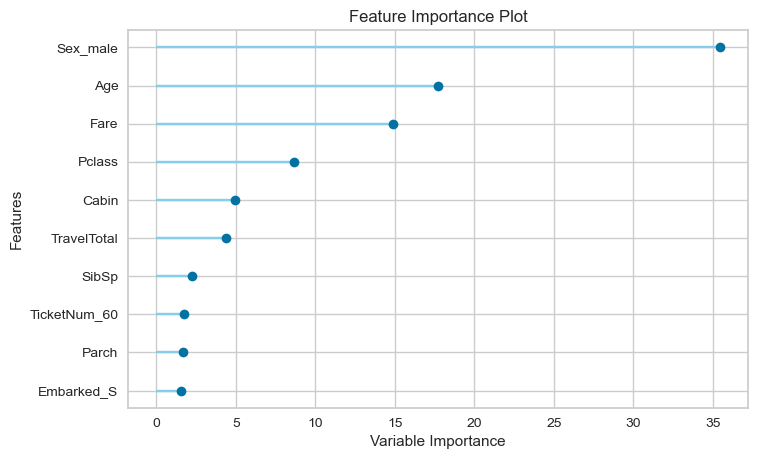

In [43]:
plot_model(top[1], plot='feature')

Feature Importance av CatBoost Regressor

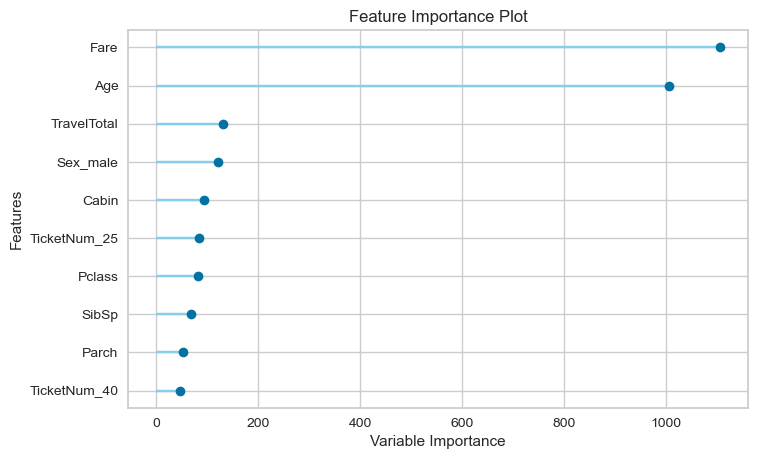

In [44]:
plot_model(top[2], plot='feature')

Feature Importance av LGBM Regressor

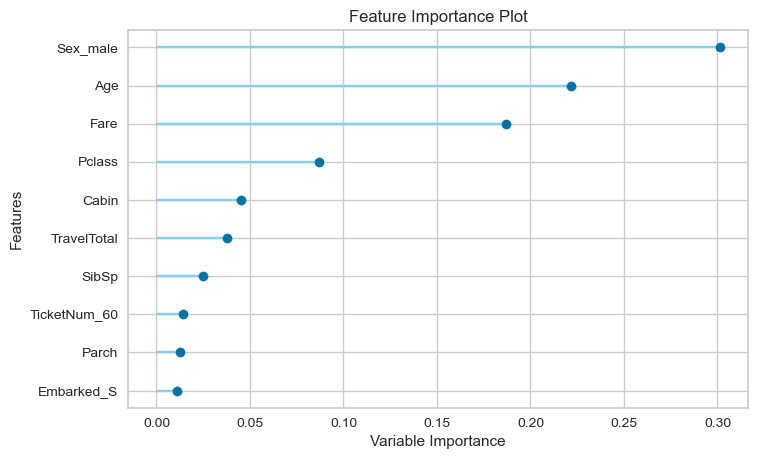

In [45]:
plot_model(top[3], plot='feature')

Feature Importance av Random Forest Regressor

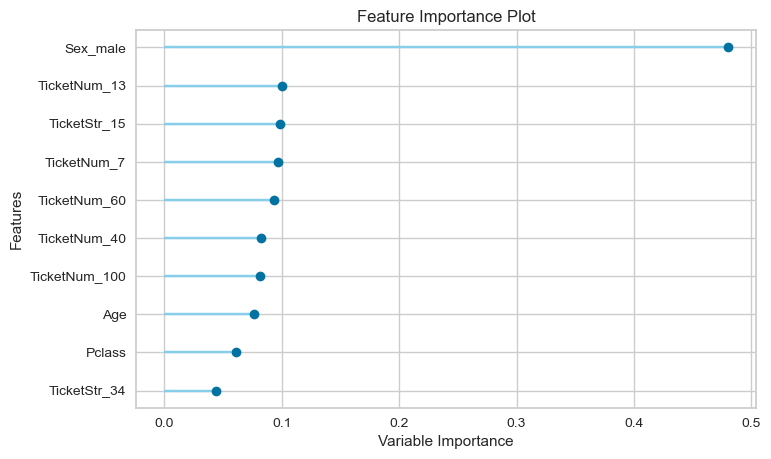

In [46]:
plot_model(top[4], plot='feature')

Feature Importance av Bayesian Ridge

Disse feature importance plottene brukes blant annet til å finne ut hvor viktige ulike features noe som kan gi en god indikasjon på om noen bør fjernes eller endres på

In [47]:
top_models = top[0:]

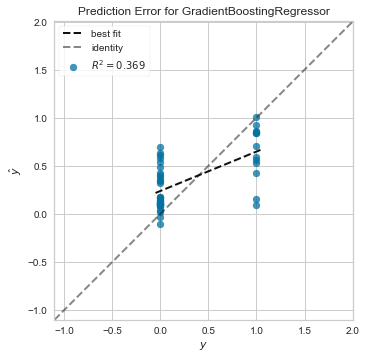

In [48]:
plot_model(top[0], plot='error')

Her får en en indikasjon på hvor godt modellen er basert på de resterende 5% av datene som ble holdt borte av testsettet. Dette er en modell av gradient boost regressoren.

## 6. Fine-tune your models and combine them into a great solution

In [49]:
tuned_top_models = [tune_model(model, optimize='RMSE', choose_better=True, fold = 20, n_iter = 50)
                   for model in top_models]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.3607,0.1863,0.4317,0.2444,0.2996,0.4594
1,0.3217,0.1751,0.4185,0.2025,0.2957,0.4329
2,0.4050,0.2359,0.4857,0.0436,0.3384,0.4754
3,0.2648,0.1098,0.3313,0.5168,0.2413,0.3156
4,0.2895,0.1305,0.3613,0.4055,0.2617,0.3708
5,0.2843,0.1310,0.3619,0.4521,0.2462,0.4154
6,0.2905,0.1487,0.3856,0.4038,0.2592,0.4134
7,0.2474,0.1027,0.3204,0.5647,0.2266,0.3113
8,0.2724,0.1256,0.3543,0.4531,0.2529,0.3335
9,0.3731,0.2157,0.4645,0.0292,0.3240,0.4349


Her blir modellene tunet basert på RMSE og deretter lagret i tuned_top_models. Her en n_iter satt til 50 for å få en mer optimalisert modell. Den blir også utført på 20 folds isteden for 10. Dette gjør at finjusterningen tar litt lenger tid.

In [50]:
blender = blend_models(estimator_list=tuned_top_models, fold=20)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.2992,0.1350,0.3674,0.4527,0.2544,0.3804
1,0.2923,0.1836,0.4285,0.1638,0.2991,0.4061
2,0.3404,0.1938,0.4403,0.2140,0.3057,0.4135
3,0.2312,0.0842,0.2902,0.6293,0.2122,0.2650
4,0.2609,0.1212,0.3481,0.4482,0.2498,0.3435
5,0.2403,0.1088,0.3299,0.5448,0.2256,0.3447
6,0.2564,0.1239,0.3520,0.5031,0.2343,0.3660
7,0.2192,0.0921,0.3035,0.6095,0.2113,0.2876
8,0.2409,0.1185,0.3442,0.4839,0.2424,0.3041
9,0.3472,0.2078,0.4558,0.0650,0.3225,0.4378


Lager en stemme regressor basert på listen med tunede modeller som kan brukes til predikasjoner.

In [51]:
stacker = stack_models(estimator_list=tuned_top_models, meta_model=tuned_top_models[2], fold=20)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.2773,0.1383,0.3719,0.4392,0.2614,0.3346
1,0.3008,0.2164,0.4652,0.0143,0.3223,0.4353
2,0.3251,0.1879,0.4335,0.2380,0.2988,0.4098
3,0.2607,0.1155,0.3398,0.4915,0.2460,0.2874
4,0.2887,0.1661,0.4075,0.2437,0.2835,0.3650
5,0.2509,0.1350,0.3675,0.4351,0.2546,0.3023
6,0.2268,0.1117,0.3341,0.5524,0.2238,0.3282
7,0.2266,0.0987,0.3142,0.5814,0.2244,0.2810
8,0.2393,0.1245,0.3529,0.4576,0.2501,0.2852
9,0.3518,0.2360,0.4858,-0.0620,0.3373,0.4475


Denne modellen er en stacker noe som betyr at den kombinerer flere modeller som en meta model trenes på. I likhet med en blender kan denne også brukes til å gi predikasjoner.

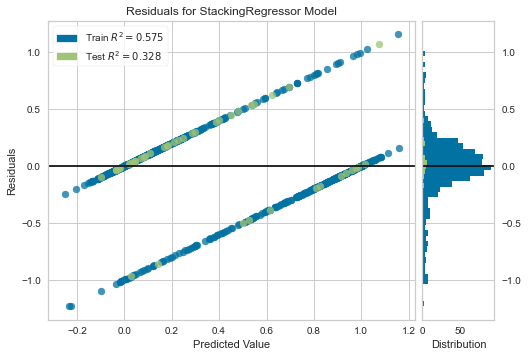

In [52]:
plot_model(stacker)

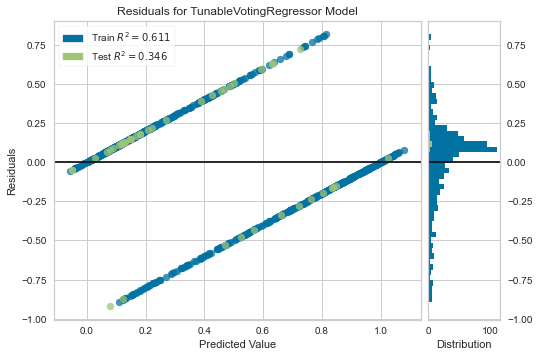

In [53]:
plot_model(blender)

Disse modellene for Residuals sier noe om predikerte verdier mot observerte verdier. Stacker ser ut til å gi best resultat

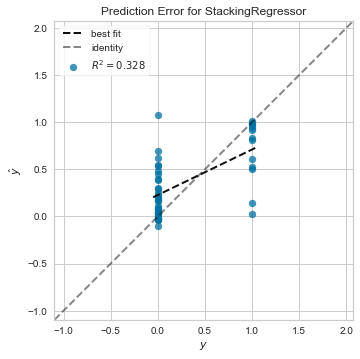

In [54]:
plot_model(stacker, plot='error')

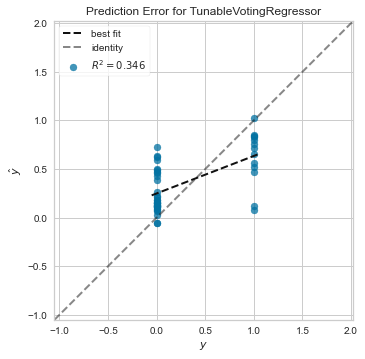

In [55]:
plot_model(blender, plot='error')

Her vises error plot for både blender og stacker, hvor stacker ser ut til å gi best resultat

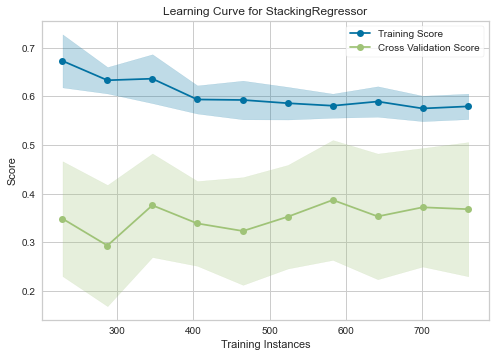

In [56]:
plot_model(stacker, plot='learning')

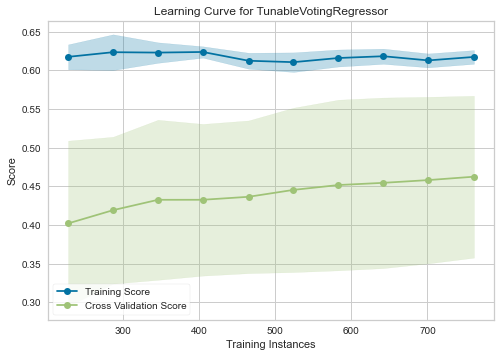

In [57]:
plot_model(blender, plot='learning')

In [58]:
predict_model(stacker);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Stacking Regressor,0.2565,0.1381,0.3716,0.3280,0.2707,0.2923


In [59]:
predict_model(blender);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.2882,0.1343,0.3665,0.3463,0.2693,0.3686


In [60]:
finalModelStack = finalize_model(stacker)

In [61]:
predict_model(finalModelStack)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Stacking Regressor,0.2142,0.0927,0.3045,0.5486,0.2191,0.3208


,TravelTotal,Parch,SibSp,Age,Pclass,Fare,Cabin,TicketStr_15,TicketStr_25,TicketStr_34,...,TicketNum_40,TicketNum_60,TicketNum_7,Embarked_C,Embarked_Q,Embarked_S,Embarked_not_available,Sex_male,Survived,Label
0,0.000,0.000,0.000,0.000,2.000,-0.309,0.000,0.000,0.000,1.000,...,1.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0,-0.112
1,1.000,0.000,1.000,0.462,1.000,0.280,0.000,0.000,0.000,1.000,...,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0,-0.039
2,0.000,0.000,0.000,0.000,2.000,0.345,0.000,0.000,0.000,1.000,...,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0,-0.023
3,1.000,1.000,0.000,-0.077,2.000,-0.085,45.000,0.000,0.000,1.000,...,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1,0.710
4,0.000,0.000,0.000,0.000,1.000,-0.041,0.000,0.000,0.000,1.000,...,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0,-0.011
5,0.000,0.000,0.000,0.154,2.000,-0.309,0.000,0.000,0.000,1.000,...,1.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0,0.166
6,3.000,2.000,1.000,1.538,1.000,2.162,0.000,0.000,0.000,1.000,...,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1,0.923
7,0.000,0.000,0.000,0.000,2.000,-0.309,0.000,0.000,0.000,1.000,...,1.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0,-0.112
8,2.000,0.000,2.000,1.692,0.000,5.098,0.000,0.000,0.000,0.000,...,0.000,1.000,0.000,0.000,0.000,1.000,0.000,1.000,1,0.268
9,0.000,0.000,0.000,3.231,1.000,-0.169,0.000,0.000,0.000,1.000,...,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0,0.125


In [62]:
finalModelBlend = finalize_model(blender)

In [63]:
predict_model(finalModelBlend)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.2480,0.1012,0.3181,0.5076,0.2345,0.3248


,TravelTotal,Parch,SibSp,Age,Pclass,Fare,Cabin,TicketStr_15,TicketStr_25,TicketStr_34,...,TicketNum_40,TicketNum_60,TicketNum_7,Embarked_C,Embarked_Q,Embarked_S,Embarked_not_available,Sex_male,Survived,Label
0,0.000,0.000,0.000,0.000,2.000,-0.309,0.000,0.000,0.000,1.000,...,1.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0,0.158
1,1.000,0.000,1.000,0.462,1.000,0.280,0.000,0.000,0.000,1.000,...,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0,0.073
2,0.000,0.000,0.000,0.000,2.000,0.345,0.000,0.000,0.000,1.000,...,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0,0.089
3,1.000,1.000,0.000,-0.077,2.000,-0.085,45.000,0.000,0.000,1.000,...,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1,0.723
4,0.000,0.000,0.000,0.000,1.000,-0.041,0.000,0.000,0.000,1.000,...,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0,0.166
5,0.000,0.000,0.000,0.154,2.000,-0.309,0.000,0.000,0.000,1.000,...,1.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0,0.145
6,3.000,2.000,1.000,1.538,1.000,2.162,0.000,0.000,0.000,1.000,...,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1,0.854
7,0.000,0.000,0.000,0.000,2.000,-0.309,0.000,0.000,0.000,1.000,...,1.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0,0.158
8,2.000,0.000,2.000,1.692,0.000,5.098,0.000,0.000,0.000,0.000,...,0.000,1.000,0.000,0.000,0.000,1.000,0.000,1.000,1,0.267
9,0.000,0.000,0.000,3.231,1.000,-0.169,0.000,0.000,0.000,1.000,...,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0,0.084


Her ser vi at stacker gir best resultat så dette blir den modellen vi bruker til å gi predikasjoner.

## Present your solution:

In [64]:
test.loc[test['Ticket'].str[0].str.isnumeric(), 'Ticket'] = "X " + test['Ticket']
test[['TicketStr', 'TicketNum']] = test['Ticket'].str.split(' ', 1, expand=True)
test['TicketStr'] = test['TicketStr'].str[0]
test['TicketNum'] = test['TicketNum'].str[0]

test.loc[(test['TicketStr'] == 'A'), 'TicketStr'] = 6
test.loc[(test['TicketStr'] == 'W'), 'TicketStr'] = 15
test.loc[(test['TicketStr'] == 'L'), 'TicketStr'] = 25
test.loc[(test['TicketStr'] == 'S'), 'TicketStr'] = 32
test.loc[(test['TicketStr'] == 'C'), 'TicketStr'] = 34
test.loc[(test['TicketStr'] == 'X'), 'TicketStr'] = 38
test.loc[(test['TicketStr'] == 'F'), 'TicketStr'] = 57
test.loc[(test['TicketStr'] == 'P'), 'TicketStr'] = 65
test['TicketStr'] = test.TicketStr.astype(int)


test["TicketNum"] = test['TicketNum'].replace(np.nan,40)
test.loc[(test['TicketNum'] == '8'), 'TicketNum'] = 0
test.loc[(test['TicketNum'] == '6'), 'TicketNum'] = 7
test.loc[(test['TicketNum'] == '5'), 'TicketNum'] = 13
test.loc[(test['TicketNum'] == '4'), 'TicketNum'] = 13
test.loc[(test['TicketNum'] == '3'), 'TicketNum'] = 25
test.loc[(test['TicketNum'] == '7'), 'TicketNum'] = 26
test.loc[(test['TicketNum'] == '2'), 'TicketNum'] = 40
test.loc[(test['TicketNum'] == '1'), 'TicketNum'] = 60
test.loc[(test['TicketNum'] == '9'), 'TicketNum'] = 100
test.loc[(test['TicketNum'] == 'B'), 'TicketNum'] = 100
test['TickerNum'] = test.TicketNum.astype(int)

test['Cabin'] = test['Cabin'].str[0]
test['Cabin'] = test['Cabin'].replace(np.nan, 'X')
##train["AgeGroup"].fillna((train["AgeGroup"].mean()), inplace=True)
test.loc[(test['Cabin'] == 'X') | (test['Cabin'] == 'T'), 'Cabin'] = 30
test.loc[(test['Cabin'] == 'A') | (test['Cabin'] == 'G'), 'Cabin'] = 46
test.loc[(test['Cabin'] == 'C') | (test['Cabin'] == 'F'), 'Cabin'] = 60
test.loc[(test['Cabin'] == 'E') | (test['Cabin'] == 'D') | (test['Cabin'] == 'B'), 'Cabin'] = 75
test['Cabin'] = test.Cabin.astype(int)

test["TravelTotal"] = test['SibSp'] + test['Parch']
test['Age'].fillna((test['Age'].mean()), inplace=True)

test = test[['PassengerId','TravelTotal','Parch','SibSp','Age','Pclass','Fare','Cabin','TicketStr','TicketNum','Embarked','Sex']]

In [65]:
test.head()

,PassengerId,TravelTotal,Parch,SibSp,Age,Pclass,Fare,Cabin,TicketStr,TicketNum,Embarked,Sex
0,892,0,0,0,34.500,3,7.829,30,38,25,Q,male
1,893,1,0,1,47.000,3,7.000,30,38,25,S,female
2,894,0,0,0,62.000,2,9.688,30,38,40,Q,male
3,895,0,0,0,27.000,3,8.662,30,38,25,S,male
4,896,2,1,1,22.000,3,12.287,30,38,25,S,female


Fikser test settet likt som treningssettet

In [66]:
test_predictions = predict_model(finalModelStack, data=test)
test_predictions['Label'] = test_predictions.Label.round(0).astype(int)
test_predictions.head()

,PassengerId,TravelTotal,Parch,SibSp,Age,Pclass,Fare,Cabin,TicketStr,TicketNum,Embarked,Sex,Label
0,892,0,0,0,34.500,3,7.829,30,38,25,Q,male,0
1,893,1,0,1,47.000,3,7.000,30,38,25,S,female,0
2,894,0,0,0,62.000,2,9.688,30,38,40,Q,male,0
3,895,0,0,0,27.000,3,8.662,30,38,25,S,male,0
4,896,2,1,1,22.000,3,12.287,30,38,25,S,female,0


Label kolonnen er de gitte predikasjonene til modellen.

In [67]:
save_model(finalModelStack, 'Final Model 20.0 17.11.2020')

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['TicketStr',
                                                             'TicketNum'],
                                       display_types=True, features_todrop=[],
                                       id_columns=['PassengerId'],
                                       ml_usecase='classification',
                                       numerical_features=['SibSp', 'Parch',
                                                           'Cabin',
                                                           'TravelTotal'],
                                       target='Survived', time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_ava...
                                                                  feature_fraction=0.7,
                                                                  importance_type='split',
              

Lagrer modell til deployment.

In [68]:
titanicSub = test_predictions[['PassengerId','Label']]

In [69]:
titanicSub = titanicSub.rename(columns={'Label': 'Survived'})

In [70]:
titanicSub.to_csv('titanicSub15.csv', index=False)

Resultat csv til kraggle.

## Launch, monitor and maintain your system:


Nå som modellen er laget og lagret, kan den brukes i deployment. Ettersom denne er basert på en hendelse for over 100 år siden, vil ikke noen ny data bli tilgjengelig. Det er derfor veldig begrenset når det kommer til vedlikehold av modellen. Når det gjelder observasjon, er det vanskelig å vite om den gir gode predikasjoner på ny data ettersom denne vil være imaginær. Det er alikvevel mulig å fortsette å videreutvikle modellen ut fra allerede eksisterende data å prøve å forbedre den yterligere. 

Vi har automatisert Deployment med Azure DevOps hvor vi har laget pipelines.

1. Api pipelinen henter automatisk fastAPI appen fra /api mappen i GitHub og lager en docker container som blir pushet opp i Azure Container Registery. Herfra vil vår container instance hente nyeste container.

2. Frontend pipelinen henter automatisk React appen fra /web mappen i Github og deployer automatisk på Azure WEb App Services.

Pipelinene aktiveres automatisk hver gang vi pusher en ny commit til GitHuben.
Dermed kan vi enkelt forbedre appen kontinuerlig ved å feks legge til funksjoner på API eller web applikasjonen. Hvis vi også greier å tune modellen enda bedre, så kan det enkelt pushes til produksjon.

Ellers gjør REST api vår det lett å deploye modellen til andre platformer, som f.eks en mobil app.

